# Aggregate hourly data to monthly/annual percentiles

| Var                       | percentile | monthly | annual |
|---------------------------|------------|---------|--------|
| CAMS PM10 daily mean      | 0.9041     |    x    |   x    | 
| CAMS O3 daily max 8h mean | 0.9315     |    x    |   x    | 



In [1]:
import gc
import glob
import multiprocessing
import multiprocessing.popen_spawn_posix
import os.path
import threading

import dask
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from dask.distributed import Client, LocalCluster, Lock, progress

import matplotlib.pyplot as plt
%matplotlib inline

os.chdir(
    "/mnt/cloud/wwu1/ec_bronze/_nogroup/ae78a1ca-a0e8-4e4e-8992-69c34947db65/UseCase_AIRCON"
)
years = range(2015, 2024)
variables = ['pm10', 'o3']

In [12]:
client = Client()
# client

## Daily Aggregates

- O3: maximum 8-hour rolling mean per day

In [14]:
def remove_expver(x):
    if "expver" in x.dims:
        x = x.reduce(np.nansum, "expver")
        print(f"\nFound experimental version data from {y}. Reducing dimensions.")
    return x
    
def remove_level(x):
    if "level" in x.coords:
        x = x.reduce(np.nansum, "level")
        print(f"\nFound level variable in data from {y}. Reducing dimensions.")
    return x

def set_labels(x):
    x = remove_level(x)
    x = remove_expver(x) 
    if 'o3_conc' in x.variables:
        x = x.rename_vars({'o3_conc': 'o3'})
    if 'longitude' in x.coords:
        x = x.rename({'longitude': 'lon'})
    if 'latitude' in x.coords:
        x = x.rename({'latitude': 'lat'})
    return x
          
def extend_ts_prior(y, n):
    
    # hourly O3 data of year y
    files_t1 = glob.glob(f"supplementary/cams_download/*o3*{y}*")  # all months of year y
    files_t1.sort()
    
    if y > 2022:
        t1 = xr.open_mfdataset(files_t1, chunks = 'auto', concat_dim = "time", combine = "nested") 
        t1.coords['time'] = pd.date_range(start=f"{y}-01-01 00:00:00", end = f"{y}-12-31 23:00:00", freq='H')
        print(f"\nFound deltatimeIndex for data from {y}. Reindexing with hourly datetime.")
    else:
        t1 = xr.open_mfdataset(files_t1, chunks="auto", parallel=True)
    t1 = set_labels(t1)
    
    # last n hours of the previous year for rolling mean calculation
    file_t0 = glob.glob(f"supplementary/cams_download/*o3*{y-1}*")
    file_t0.sort()
    file_t0 = file_t0[-1]  # december of previous year
    t0 = xr.open_mfdataset(file_t0, chunks="auto", parallel=True)
    t0_dim = t0.dims["time"]
    prev_n = range((t0_dim - n), t0_dim)
    t0 = t0.isel(time=prev_n)  # only last 10 hours of december
    t0 = set_labels(t0)
    
    # compare grids and warp if necessary
    lon0 = t0.dims.get("lon")
    lat0 = t0.dims.get("lat")
    lon1 = t1.dims.get("lon")
    lat1 = t1.dims.get("lat")

    if (lon0 == lon1) and (lat0 == lat1):  # do grids match?
        print("Grid dimensions match.")
        t_concat = xr.concat([t0, t1], dim="time", join="right")
    else:
        match_out = (f"supplementary/cams_o3_hourly/cams_o3_hourly_matched_{n}h_prior_to_{y}.nc")

        if os.path.isfile(match_out) and os.path.getsize(match_out) > 50000:
            print("Grid dimensions differ --> reading warped data from file.")
            t_concat = xr.concat([xr.open_mfdataset(match_out), t1], dim="time")
        else:
            print("Grid dimensions differ --> warping data to common grid.")
            t0_rio = (
                rioxarray.open_rasterio(file_t0, chunks=True)
                .rio.write_crs("EPSG:4326")
                .isel(time=prev_n)
            )  # last 10 hour of december
            t1_rio = (
                rioxarray.open_rasterio(files_t1[0], chunks=True)
                .rio.write_crs("EPSG:4326")
                .isel(time=1)
            )  # first hour of january as reference
            t0_rio_match = (
                t0_rio.rio.reproject_match(t1_rio)
                .to_dataset()
                .rename_dims({"x": "lon", "y": "lat"})
                .rename_vars({"x": "lon", "y": "lat"})
            )
            t0_rio_match["lat"] = t1["lat"]
            t0_rio_match["lon"] = t1["lon"]
            t0_rio_match.to_netcdf(match_out, mode="w")
            t_concat = xr.concat([xr.open_mfdataset(match_out), t1], dim="time")
            del t0, t1, t0_rio, t1_rio, t0_rio_match
    return t_concat

def daily_max_rolling(y, n):
    
    out = f"supplementary/01_daily/o3_daily_max_{n}h_mean_{y}.nc"
    agg = None
    if not os.path.isfile(out) or os.path.getsize(out) < 100000:     
        ts_h = extend_ts_prior(y, n)                                                # extend data left 8 h into previous year
        ts_roll = ts_h.o3.rolling(time=n, center=False).mean().to_dataset()         # rolling mean
        ts_roll = ts_roll.isel(time=(ts_roll.time.dt.year == y))                    # limit to year y
        agg = (
            ts_roll
            .resample(time="D")
            .max(skipna=True)                                                       # daily maximum 
            .to_netcdf(out, mode="w", compute=False)
        )
    else: 
        print("already processed")
    return agg

In [15]:
lazy_results = []

for y in years:
    print(y, sep=" ", end=" ", flush=True)
    agg_d = daily_max_rolling(y, n=8)
    lazy_results.append(agg_d)

2015 already processed
2016 already processed
2017 already processed
2018 already processed
2019 already processed
2020 already processed
2021 already processed
2022 already processed
2023 
Found deltatimeIndex for data from 2023. Reindexing with hourly datetime.

Found level variable in data from 2023. Reducing dimensions.
Grid dimensions match.


In [16]:
len(lazy_results)

9

In [17]:
lazy_results = [x for x in lazy_results if x is not None]
len(lazy_results)

1

In [18]:
agg_res = dask.persist(*lazy_results)
progress(agg_res)

VBox()

## Monthly and Annual Aggregates

both from daily aggregates

- PM10: temporal percentile 90.41 of (already processed) daily means
- O3: temporal percentile 93.15 of (already processed) maximum 8-hour rolling mean per day

In [13]:
def temp_aggregate_percentile(var, y, p, t):
    timesteps = {'M': '02_monthly', 'Y': '03_annual'}
    s = timesteps[t]
    
    out = f"supplementary/{s}/{var}_{s[3:]}_perc_{y}.nc"
    agg = None
    if not os.path.isfile(out) or os.path.getsize(out) < 50000:
        file = glob.glob(f"supplementary/01_daily/{var}_daily*{y}.nc")[0]
        var_d = xr.open_mfdataset(file, chunks={'time': 366}, parallel=True)
        agg = (
            var_d
            .resample(time=t)
            .quantile(p, skipna=True)
            #.max(skipna=True)    
            .to_netcdf(out, mode="w", compute=False)
        )
    return agg

In [16]:
t = temp_aggregate_percentile('pm10', 2016, p=0.9041, t = "M")
agg_res = dask.persist(t)
progress(agg_res)

VBox()

In [26]:
%%time

lazy_results = []

for y in years:
    agg_pm10_mon = temp_aggregate_percentile('pm10', y, p=0.9041, t = "M")
    agg_pm10_ann = temp_aggregate_percentile('pm10', y, p=0.9041, t = "Y")
    lazy_results.append(agg_pm10_mon)
    lazy_results.append(agg_pm10_ann)
    
    agg_o3_mon = temp_aggregate_percentile('o3', y, p=0.9315, t = "M")
    agg_o3_ann = temp_aggregate_percentile('o3', y, p=0.9315, t = "Y")
    lazy_results.append(agg_o3_mon)
    lazy_results.append(agg_o3_ann)
    
    print(y, sep=" ", end=" ", flush=True)

2015 2016 2017 2018 2019 2020 2021 2022 2023 CPU times: user 2.12 s, sys: 227 ms, total: 2.35 s
Wall time: 3.67 s


In [27]:
lazy_results = [x for x in lazy_results if x is not None]
len(lazy_results)

18

In [28]:
agg_res = dask.persist(*lazy_results)
progress(agg_res)

VBox()

## Check and plot results

**Compare annual Ozone aggregates - mean vs. percentile**

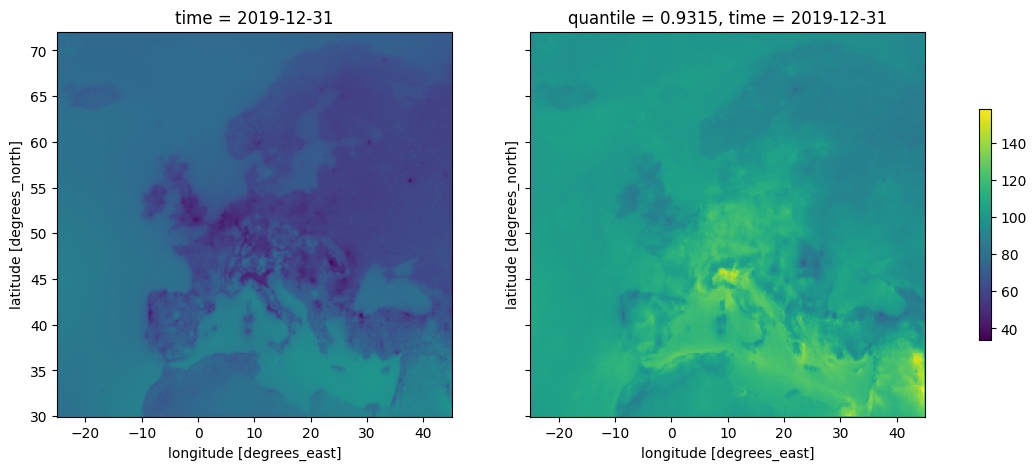

In [19]:
o3_mean = xr.open_dataset("supplementary/03_annual/o3_annual_2019.nc")
o3_perc = xr.open_dataset("supplementary/03_annual/o3_annual_perc_2019.nc")

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(14, 5))

vmin = min(o3_mean.o3.min(), o3_perc.o3.min())
vmax = max(o3_mean.o3.max(), o3_perc.o3.max())

o3_mean.o3.plot(ax=axs[0], cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)
o3_perc.o3.plot(ax=axs[1], cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)

fig.colorbar(axs[1].collections[0], ax=axs, shrink=0.6)

plt.show()

**Compare annual PM10 aggregates - mean vs. percentile**

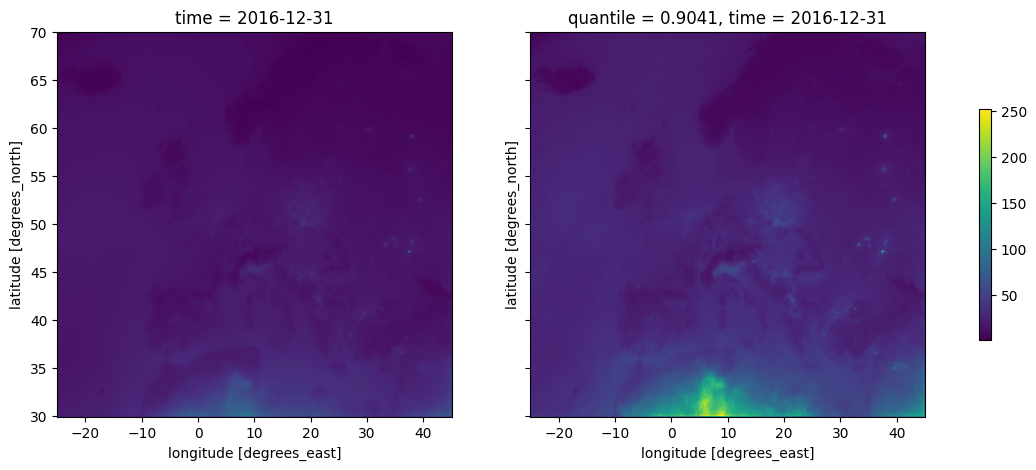

In [26]:
y = 2016
pm10_mean = xr.open_dataset(f"supplementary/03_annual/pm10_annual_{y}.nc")
pm10_perc = xr.open_dataset(f"supplementary/03_annual/pm10_annual_perc_{y}.nc")

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(14, 5))

vmin = min(pm10_mean.pm10.min(), pm10_perc.pm10.min())
vmax = max(pm10_mean.pm10.max(), pm10_perc.pm10.max())

pm10_mean.pm10.plot(ax=axs[0], cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)
pm10_perc.pm10.plot(ax=axs[1], cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)

fig.colorbar(axs[1].collections[0], ax=axs, shrink=0.6)

plt.show()

In [77]:
#fig.figure.savefig("../tests/O3_2020_mean_vs_perc.png", format="png", dpi=300)